# Bike Sharing Case Study using Linear Regression

### Problem Statement

A bike sharing company BoomBikes wants to understand the factors on which the demand for shared bikes depends. 

The company wants to know:
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands.

The firm wants to create a Linear Regression model to understand the demand of shared bikes with the available independent variables in the dataset. The model will subsequently be used by the management to understand how exactly the demands vary with different features, giving important business insights. Using the valuable information the company will refine their business strategy to meet the demand levels and customer expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market

### Solution Approach
1. Read and visualize Data
2. Preparing data for modelling
3. Training model
4. Residual Analysis
5. Predictions and Evaluation

### Step-1 Reading and Visualize Data

In [2]:
# importing required library 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import calendar

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression




In [3]:
# Read data from CSV file.
bike_df = pd.read_csv('day.csv')
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
bike_df.shape

(730, 16)

In [5]:
# There are no Null values.
# All the columns except dteday are numerical datatypes (float or int).
# # dteday is of type object. 
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### From data dictionary we understand that 
1. We have year and Month columns so the column dteday is redundant.
2. The cnt column is sum of casual and registered, so these columns can be dropped.
3. The instant column is and index, so it can be dropped.

In [6]:
bike_df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [8]:
# Converting the columns to their actual string values.
bike_df.season=bike_df.season.map({1: 'Spring',2:'Summer',3:'Fall',4:'Winter'})
bike_df.weathersit=bike_df.weathersit.map({1:'Clear',2:'Mist+Cloudy', 3:'LightSnow+Rain',4:'HeavySnow+Rain+Fog'})
bike_df.weekday=bike_df.weekday.map({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thrusday",5:"Friday",6:"Saturday"})
bike_df.mnth = bike_df.mnth.apply(lambda x: calendar.month_name[x])

In [9]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,January,0,Saturday,0,Mist+Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,January,0,Sunday,0,Mist+Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


#### Univariate Analysis

In [10]:
# Sagregating the numerical and categorical variables
cat_varlist = ['season',  'yr', 'mnth','holiday', 'weekday', 'workingday', 'weathersit']
num_varlist = ['temp','atemp','hum','windspeed','cnt']

Numerical Variables

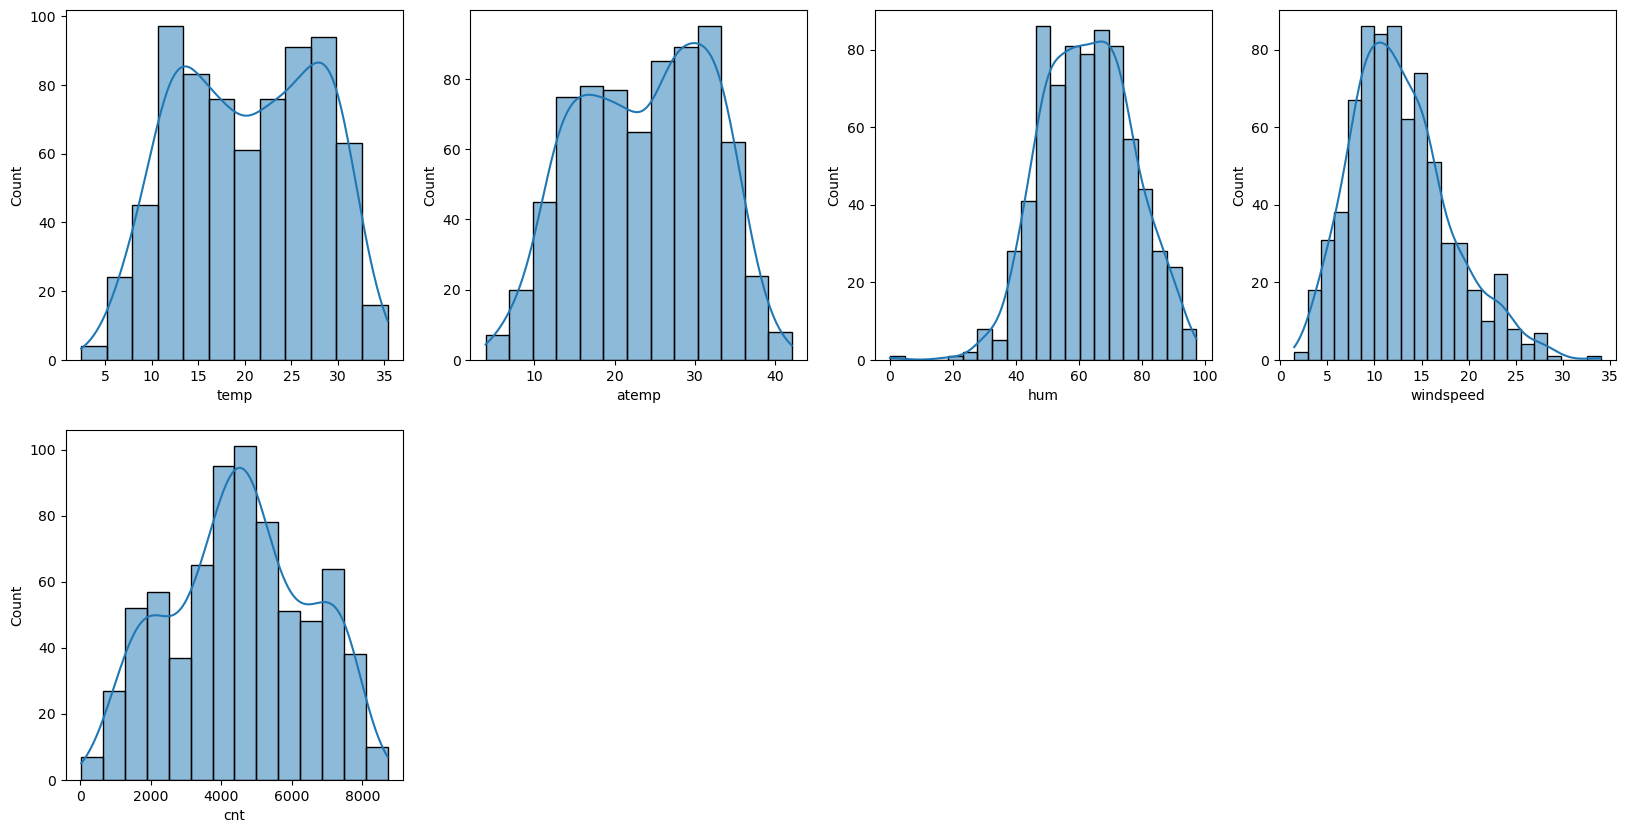

In [11]:

plt.figure(figsize=(20,10))
for i in enumerate(num_varlist):
    plt.subplot(2,4,i[0]+1)
    sns.histplot(bike_df[i[1]], kde=True)
plt.show()

Categorical Variables

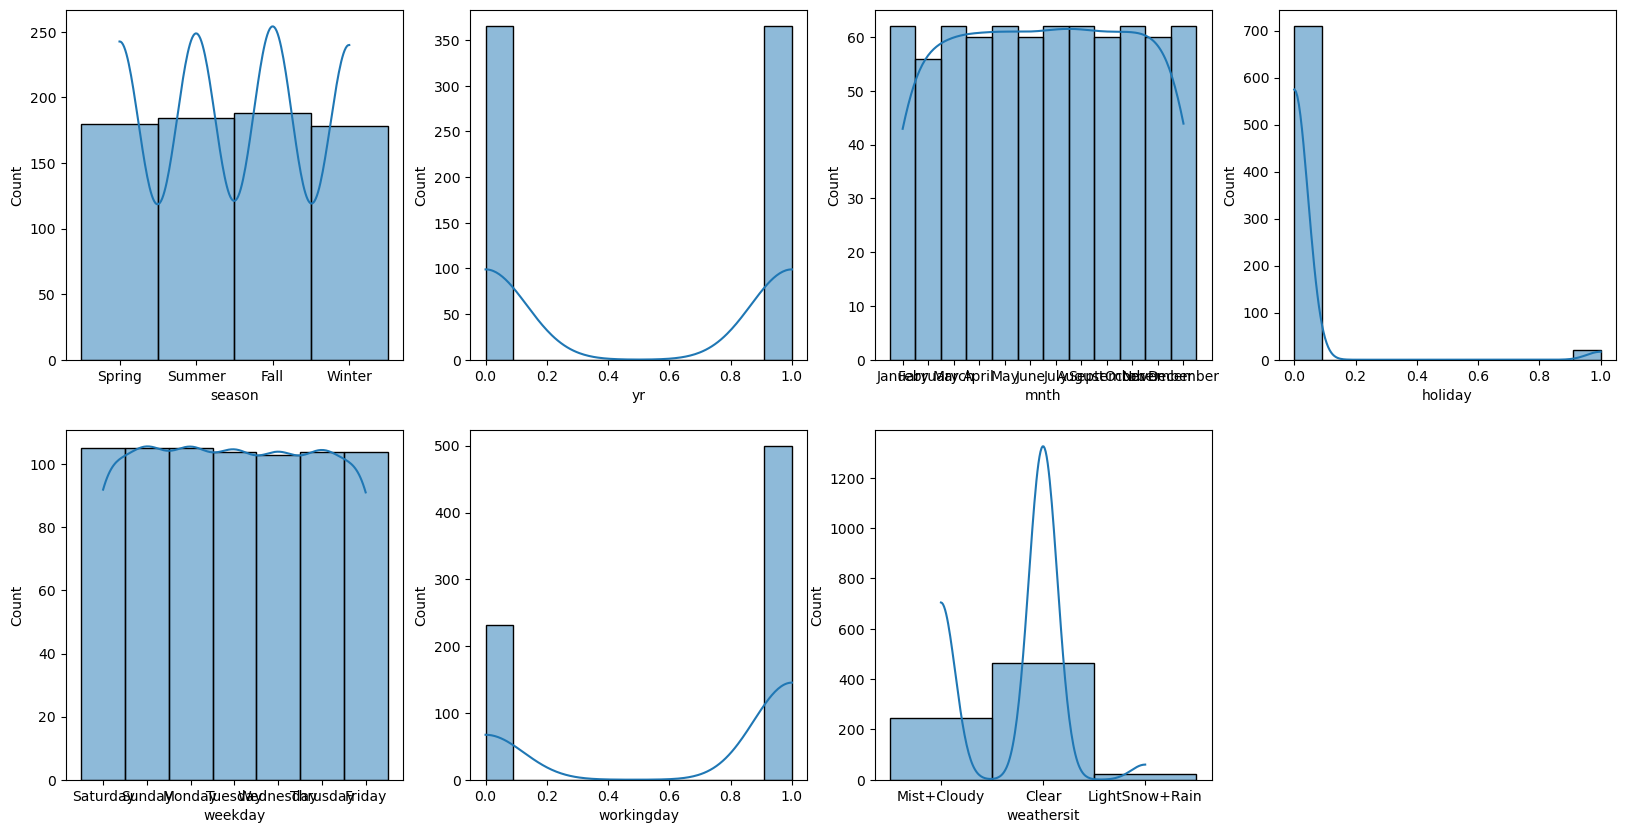

In [12]:
cat_varlist = ['season',  'yr', 'mnth','holiday', 'weekday', 'workingday', 'weathersit']
plt.figure(figsize=(20,10))
for i in enumerate(cat_varlist):
    plt.subplot(2,4,i[0]+1)
    sns.histplot(bike_df[i[1]], kde=True)
plt.show()

#### Bivariate Analysis

Numerical Variables

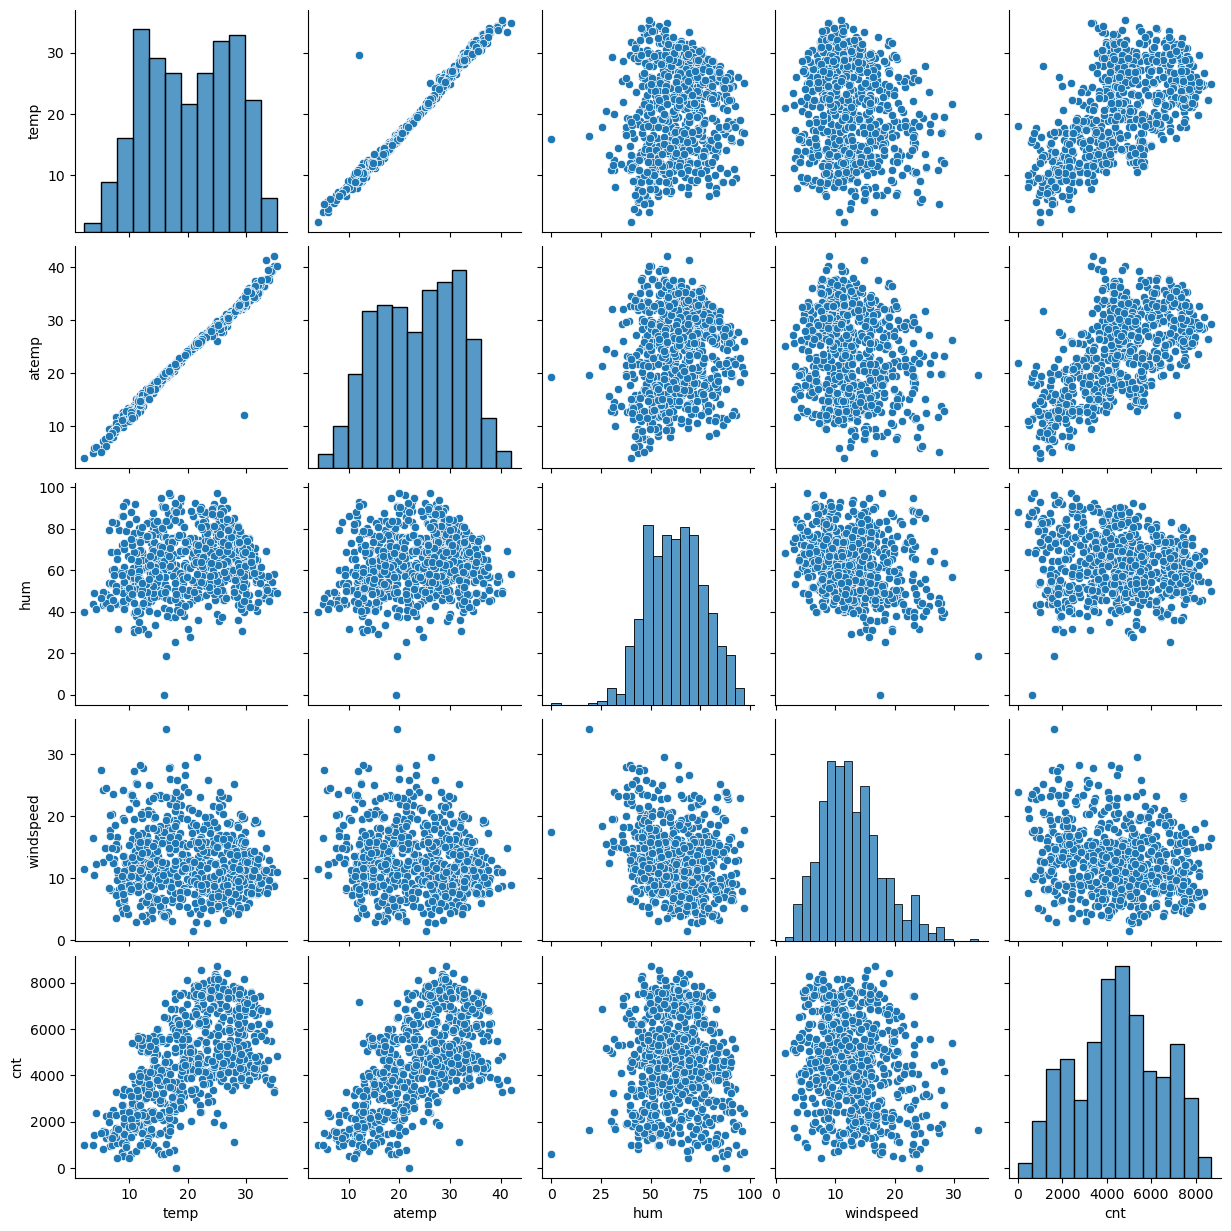

In [13]:
#visualize numerical variables
sns.pairplot(bike_df[num_varlist])
plt.show()

In [14]:
# The cnt is the target variable.
# The scatter plot shows that the cnt have positive correlation with temp and atemp variables.
# The hum and windspeed looks to be quite scattered but in the positive quadrant.

Categorical Variables

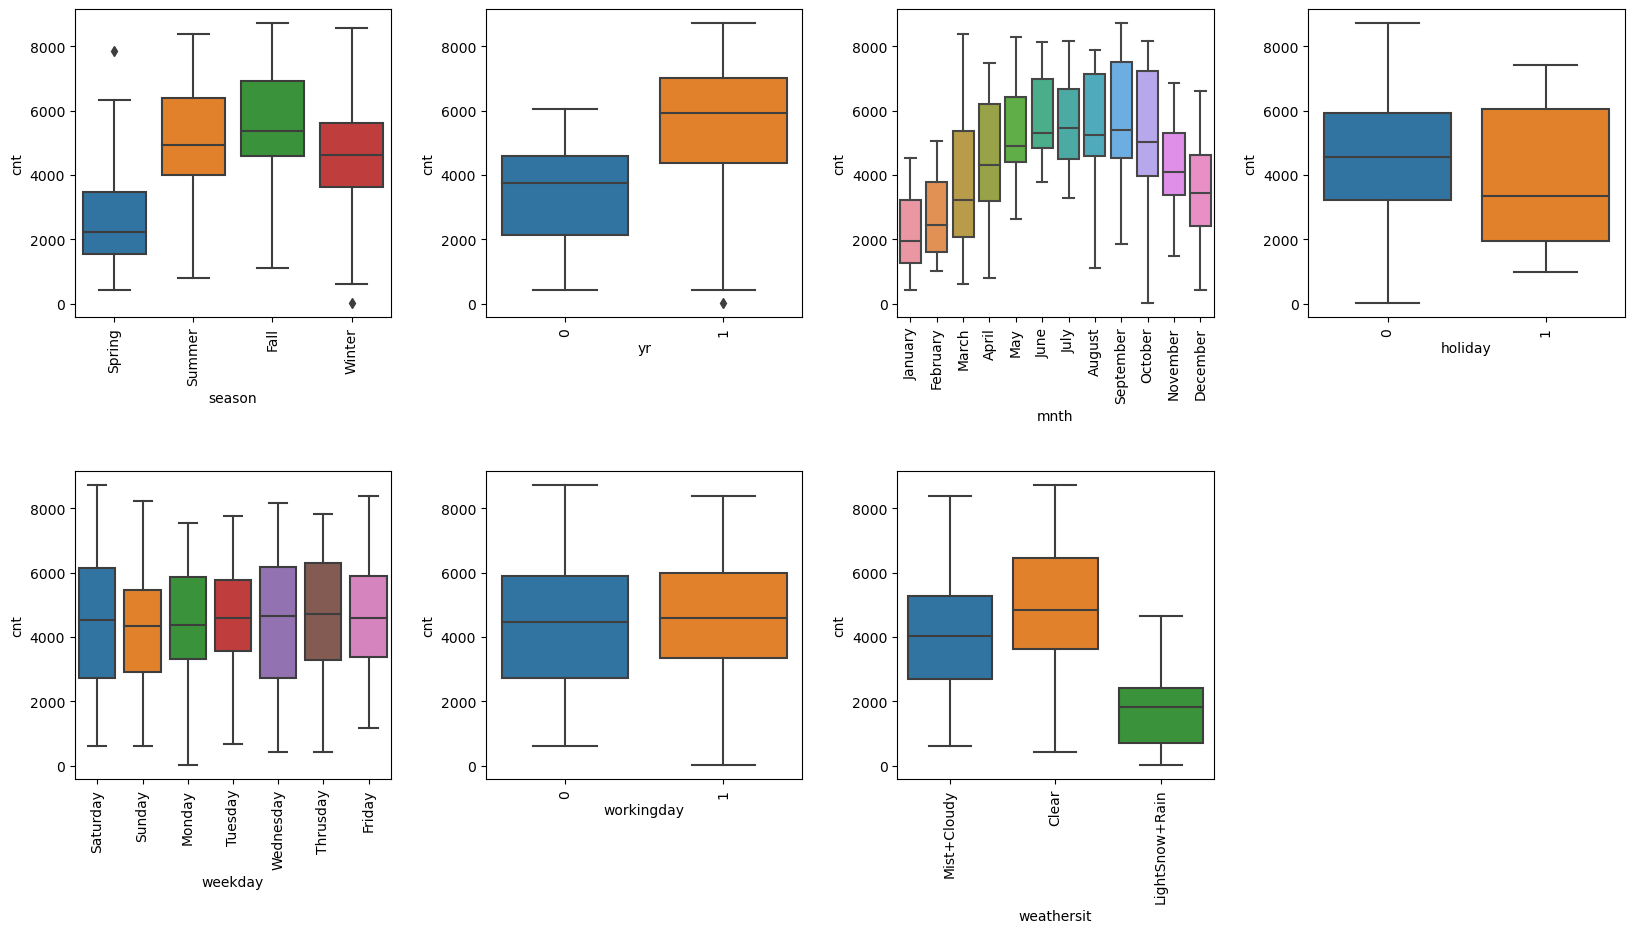

In [15]:
#visualize categorical variable
plt.figure(figsize=(20,10))

for i in enumerate(cat_varlist):
    plt.subplot(2,4,i[0]+1)
    plt.xticks(rotation=90) 
    plt.subplots_adjust(hspace=0.5, wspace=0.3) 
    sns.boxplot(x=i[1], y='cnt', data=bike_df)


The following are the observations
1. On Clear days, the demand is on higher side.
2. on Saturday's we see a slightly higher number of bike sharing.
3. In non-holiday days the demand is on higher side.

### Step 2. Preparing data for modelling

In [16]:
# Clist of categorical variables which have more than 2 values.
dummy_varlist = ['season','mnth','weekday','weathersit']
dummy=bike_df[dummy_varlist]
dummy.head()

,season,mnth,weekday,weathersit
0,Spring,January,Saturday,Mist+Cloudy
1,Spring,January,Sunday,Mist+Cloudy
2,Spring,January,Monday,Clear
3,Spring,January,Tuesday,Clear
4,Spring,January,Wednesday,Clear


In [17]:
# Create dummy variables
dummy_df = pd.get_dummies(dummy, dtype='Int64', drop_first=True)
dummy_df.head()

,season_Spring,season_Summer,season_Winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
#Concattenate the dummy variables with the bike dataframe
bike_df = pd.concat([bike_df, dummy_df], axis=1)

In [19]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
0,Spring,0,January,0,Saturday,0,Mist+Cloudy,14.110847,18.18125,80.5833,...,0,0,0,1,0,0,0,0,0,1
1,Spring,0,January,0,Sunday,0,Mist+Cloudy,14.902598,17.68695,69.6087,...,0,0,0,0,1,0,0,0,0,1
2,Spring,0,January,0,Monday,1,Clear,8.050924,9.47025,43.7273,...,0,0,1,0,0,0,0,0,0,0
3,Spring,0,January,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,...,0,0,0,0,0,0,1,0,0,0
4,Spring,0,January,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,1,0,0


In [20]:
#Dropping the dummy variable list
bike_df.drop(dummy_varlist, axis=1, inplace=True)

In [21]:
bike_df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_Spring', 'season_Summer', 'season_Winter', 'mnth_August',
       'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July',
       'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October',
       'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thrusday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_LightSnow+Rain',
       'weathersit_Mist+Cloudy'],
      dtype='object')

In [22]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   yr                         730 non-null    int64  
 1   holiday                    730 non-null    int64  
 2   workingday                 730 non-null    int64  
 3   temp                       730 non-null    float64
 4   atemp                      730 non-null    float64
 5   hum                        730 non-null    float64
 6   windspeed                  730 non-null    float64
 7   cnt                        730 non-null    int64  
 8   season_Spring              730 non-null    Int64  
 9   season_Summer              730 non-null    Int64  
 10  season_Winter              730 non-null    Int64  
 11  mnth_August                730 non-null    Int64  
 12  mnth_December              730 non-null    Int64  
 13  mnth_February              730 non-null    Int64  

In [23]:
# Splitting the dataframe into Training and Test dataset with 70-30 split.
bike_train, bike_test = train_test_split(bike_df, train_size=0.7, random_state=100)
print(f'The shape train dataset - {bike_train.shape}')
print(f'The shape of test dataset - {bike_test.shape}')

The shape train dataset - (510, 30)
The shape of test dataset - (220, 30)


In [24]:
# Rescaling the variables

#1. Create object

scaler = MinMaxScaler()

#2. Fit on data for numerical variables 
bike_train[num_varlist] = scaler.fit_transform(bike_train[num_varlist])

bike_train.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,0,0,0,0,0,0,1


In [25]:
bike_train[num_varlist].describe()

,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.542596,0.529718,0.653714,0.296763,0.518638
75%,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
y_train = bike_train.pop('cnt')
x_train = bike_train

In [27]:
y_train.head()

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64

In [28]:
x_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,season_Winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,1


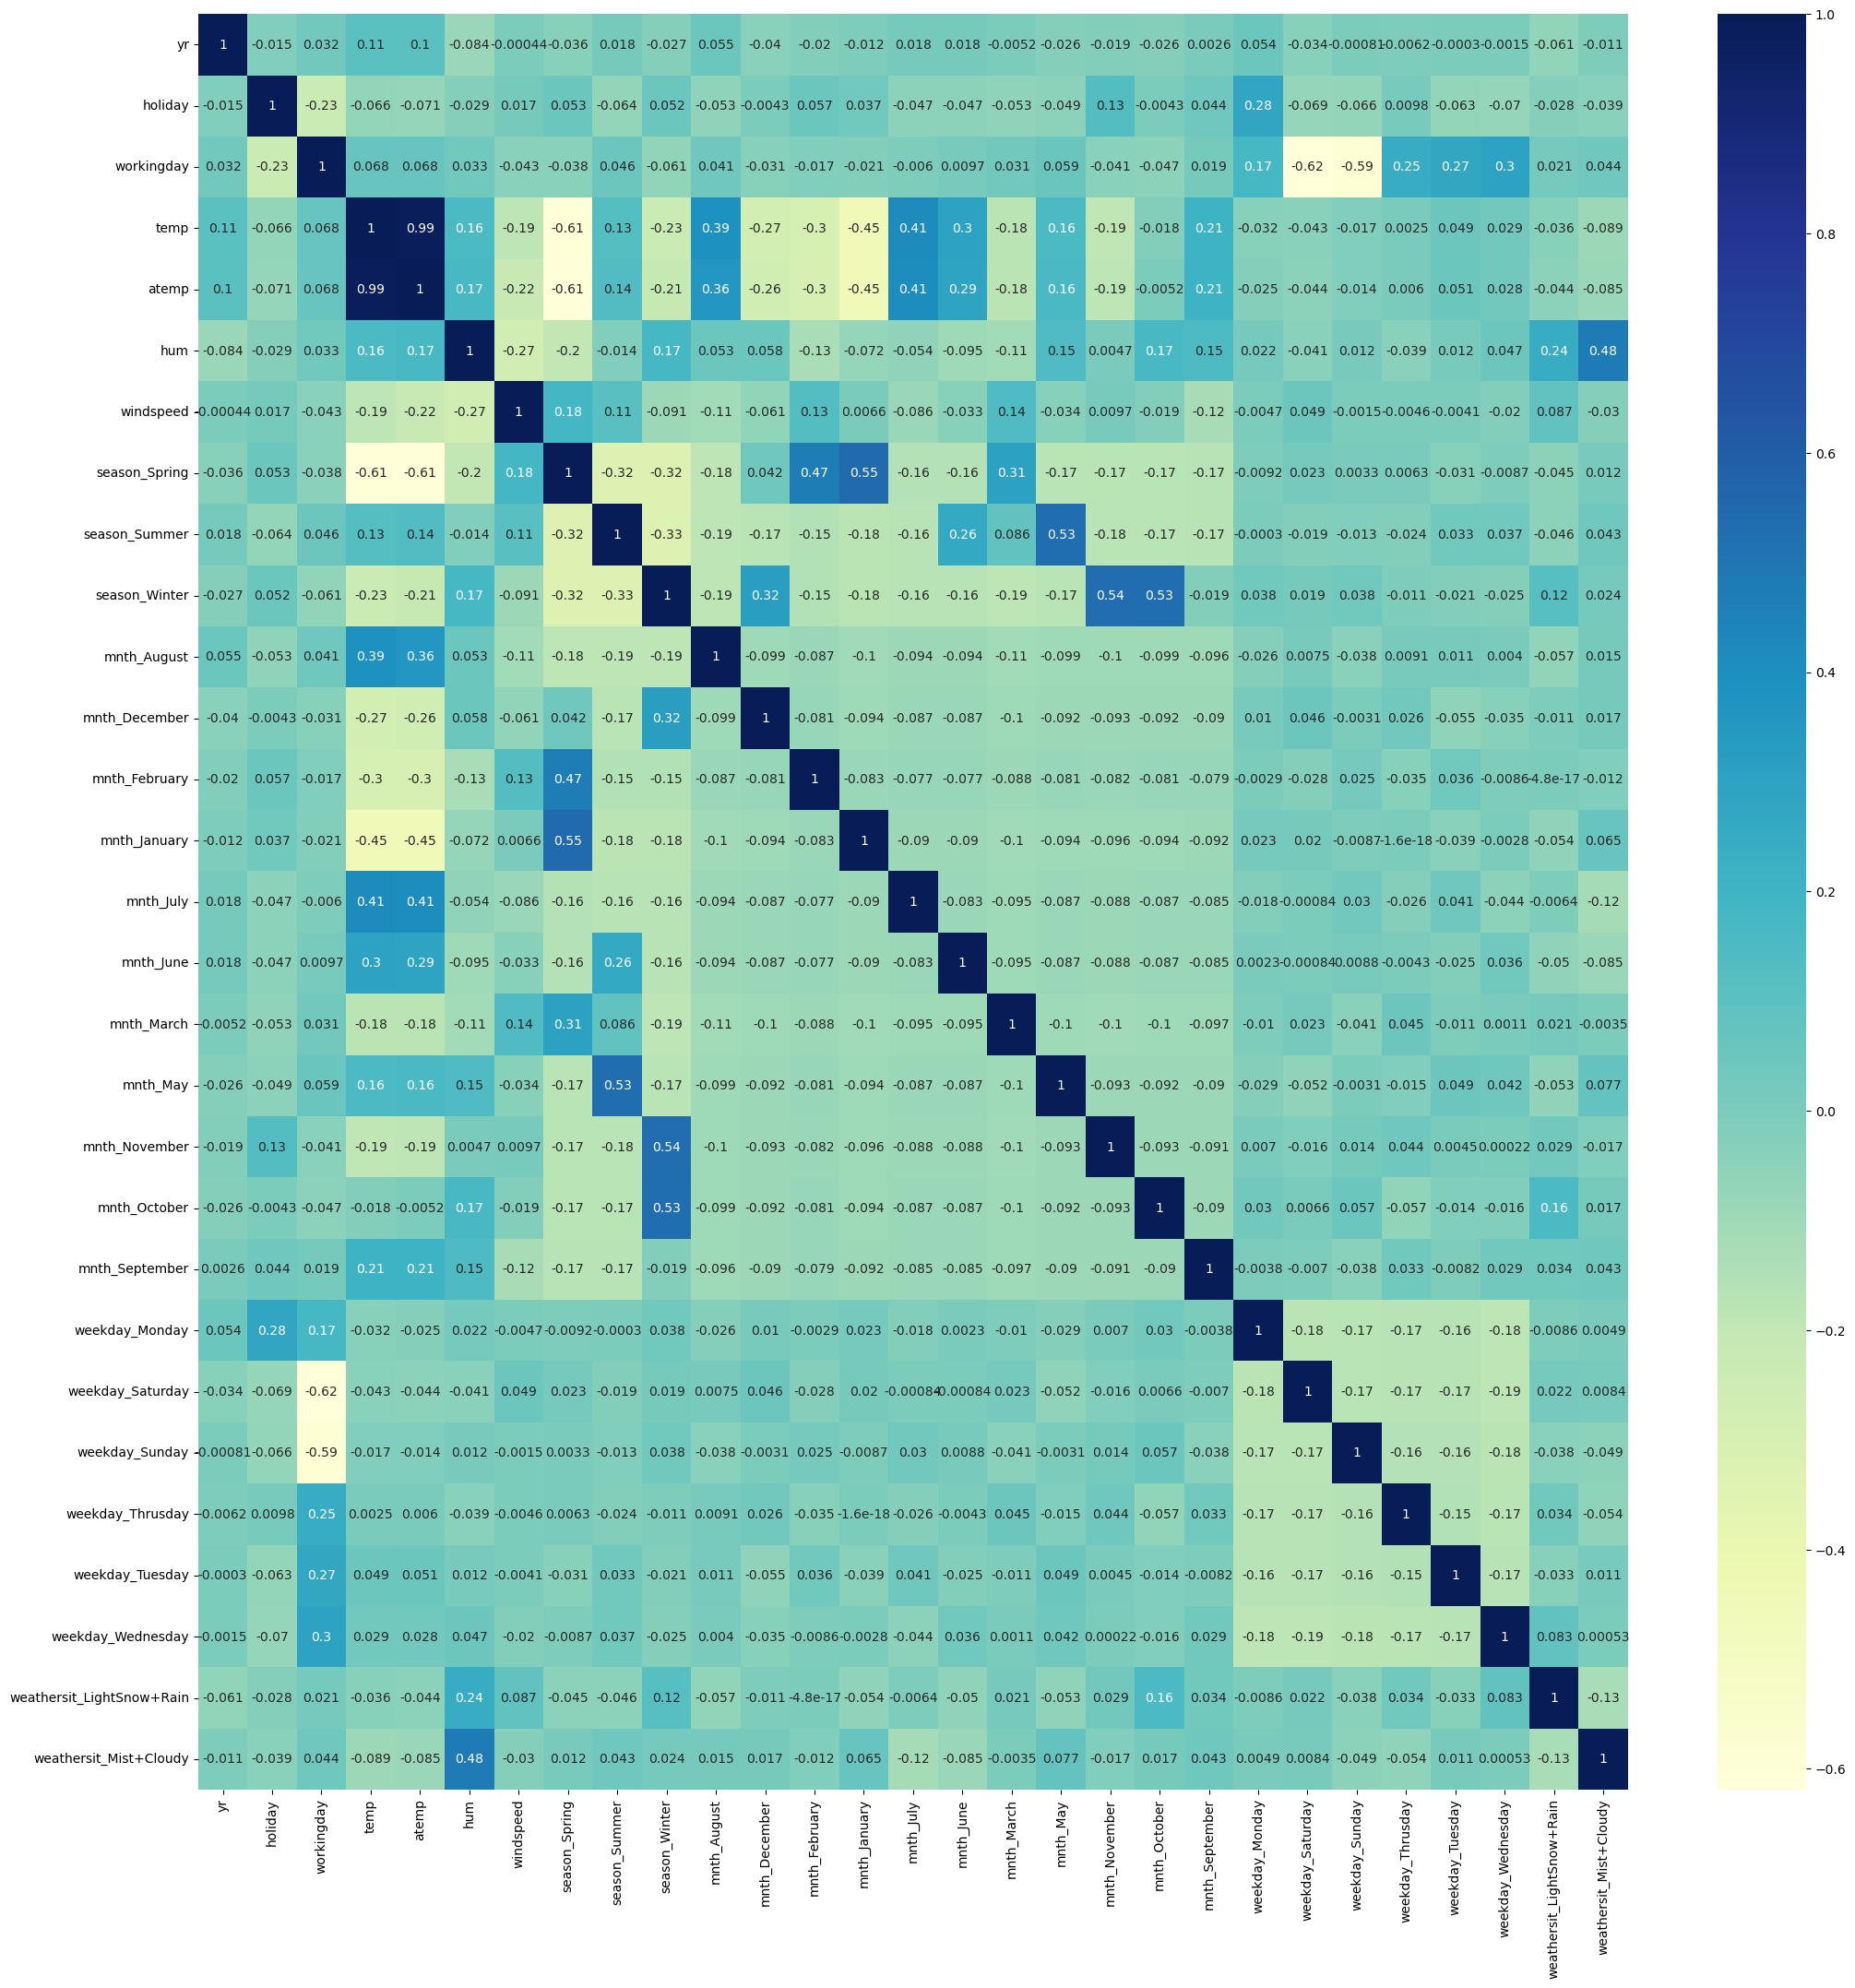

In [29]:
plt.figure(figsize = (25  , 25))
sns.heatmap(x_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Step 3. Training model

We will use a mix of automated and manual approach so that we can achieve the correct model in less iterations. For the initial phase, we will use the RFE approach number of variables as 20. Once we get the stats for the model, then we will use the p-value and VIF value to decide on the variables which can be eiliminated.

In [30]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 576 to 520
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   yr                         510 non-null    int64  
 1   holiday                    510 non-null    int64  
 2   workingday                 510 non-null    int64  
 3   temp                       510 non-null    float64
 4   atemp                      510 non-null    float64
 5   hum                        510 non-null    float64
 6   windspeed                  510 non-null    float64
 7   season_Spring              510 non-null    Int64  
 8   season_Summer              510 non-null    Int64  
 9   season_Winter              510 non-null    Int64  
 10  mnth_August                510 non-null    Int64  
 11  mnth_December              510 non-null    Int64  
 12  mnth_February              510 non-null    Int64  
 13  mnth_January               510 non-null    Int64  
 1

#### RFE for Automated feature selection

In [31]:
# Running RFE with the output number of the variable equal to 20
lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=20)           # running RFE
rfe = rfe.fit(x_train, y_train)

In [32]:
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', False, 7),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('mnth_August', True, 1),
 ('mnth_December', True, 1),
 ('mnth_February', True, 1),
 ('mnth_January', True, 1),
 ('mnth_July', True, 1),
 ('mnth_June', False, 8),
 ('mnth_March', False, 2),
 ('mnth_May', True, 1),
 ('mnth_November', True, 1),
 ('mnth_October', False, 3),
 ('mnth_September', True, 1),
 ('weekday_Monday', False, 10),
 ('weekday_Saturday', True, 1),
 ('weekday_Sunday', True, 1),
 ('weekday_Thrusday', False, 5),
 ('weekday_Tuesday', False, 9),
 ('weekday_Wednesday', False, 4),
 ('weathersit_LightSnow+Rain', True, 1),
 ('weathersit_Mist+Cloudy', True, 1)]

In [33]:
col = x_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_Summer', 'season_Winter', 'mnth_August', 'mnth_December',
       'mnth_February', 'mnth_January', 'mnth_July', 'mnth_May',
       'mnth_November', 'mnth_September', 'weekday_Saturday', 'weekday_Sunday',
       'weathersit_LightSnow+Rain', 'weathersit_Mist+Cloudy'],
      dtype='object')

In [34]:
x_train.columns[~rfe.support_]

Index(['atemp', 'season_Spring', 'mnth_June', 'mnth_March', 'mnth_October',
       'weekday_Monday', 'weekday_Thrusday', 'weekday_Tuesday',
       'weekday_Wednesday'],
      dtype='object')

After RFE we have the following model/dataset

In [35]:
x_train_rfe = x_train[col]

In [36]:
x_train_rfe.head()

,yr,holiday,workingday,temp,hum,windspeed,season_Summer,season_Winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_May,mnth_November,mnth_September,weekday_Saturday,weekday_Sunday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,0,0,1,0,0,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0,0,0,0,0,0,0,0,0,0,1,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0,0,0,1,0,0,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.504508,0.188475,1,0,0,0,0,0,0,0,0,0,1,0,0,1
111,0,0,1,0.345824,0.751824,0.380981,1,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Manual Feature Selection
Elimating variables with p-value > 0.05 and VIF > 5
<br><br>
The variables will be dropped one each time and the model will be recreated till we get model which satisfies the condition
1. p-value is less than 0.05
2. VIF of variables is less than 5

In [37]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

In [38]:
#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.1
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          1.83e-188
Time:                        11:27:42   Log-Likelihood:                 524.08
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     490   BIC:                            -923.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2079      0.026      8.097      0.000       0.157       0.258
yr                            0.2308      0.008     28.946      0.000       0.215       0.246
holiday                      -0.0096      0.021     -0.449      0.654      -0.051       0.032
workingday                    0.0840      0.009      9.120      0.000       0.066       0.102
temp                          0.4796      0.035     13.878      0.000       0.412       0.547
hum                          -0.1608      0.038     -4.281      0.000      -0.235      -0.087
windspeed                    -0.1912      0.025     -7.540      0.000      -0.241      -0.141
season_Summer                 0.0700      0.015      4.606      0.000       0.040       0.100
season_Winter                 0.1386      0.015      9.428      0.000       0.110       0.168
mnth_August                   0.0381      0.019      1.957      0.051      -0.000       0.076
mnth_December                -0.0460      0.018     -2.533      0.012      -0.082      -0.010
mnth_February                -0.0427      0.021     -2.041      0.042      -0.084      -0.002
mnth_January                 -0.0709      0.021     -3.379      0.001      -0.112      -0.030
mnth_July                    -0.0192      0.021     -0.899      0.369      -0.061       0.023
mnth_May                      0.0205      0.017      1.189      0.235      -0.013       0.054
mnth_November                -0.0400      0.019     -2.146      0.032      -0.077      -0.003
mnth_September                0.1006      0.018      5.543      0.000       0.065       0.136
weekday_Saturday              0.0933      0.011      8.279      0.000       0.071       0.115
weekday_Sunday                0.0402      0.012      3.399      0.001       0.017       0.063
weathersit_LightSnow+Rain    -0.2505      0.026     -9.597      0.000      -0.302      -0.199
weathersit_Mist+Cloudy       -0.0577      0.010     -5.582      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       76.511   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.669
Skew:                          -0.751   Prob(JB):                     4.39e-44
Kurtosis:                       5.673   Cond. No.                     1.43e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.34e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [39]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,workingday,43.65
16,weekday_Saturday,10.56
17,weekday_Sunday,10.22
3,temp,3.97
6,season_Summer,2.81
1,holiday,2.73
7,season_Winter,2.63
11,mnth_January,2.32
8,mnth_August,2.15
12,mnth_July,2.10


In [40]:
# Remove holiday column as it's p-value is 0.67
x_train_rfe.drop('holiday', axis=1, inplace=True)


In [41]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

In [42]:
#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.1
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          1.83e-188
Time:                        11:27:42   Log-Likelihood:                 524.08
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     490   BIC:                            -923.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1983      0.040      4.902      0.000       0.119       0.278
yr                            0.2308      0.008     28.946      0.000       0.215       0.246
workingday                    0.0935      0.025      3.679      0.000       0.044       0.143
temp                          0.4796      0.035     13.878      0.000       0.412       0.547
hum                          -0.1608      0.038     -4.281      0.000      -0.235      -0.087
windspeed                    -0.1912      0.025     -7.540      0.000      -0.241      -0.141
season_Summer                 0.0700      0.015      4.606      0.000       0.040       0.100
season_Winter                 0.1386      0.015      9.428      0.000       0.110       0.168
mnth_August                   0.0381      0.019      1.957      0.051      -0.000       0.076
mnth_December                -0.0460      0.018     -2.533      0.012      -0.082      -0.010
mnth_February                -0.0427      0.021     -2.041      0.042      -0.084      -0.002
mnth_January                 -0.0709      0.021     -3.379      0.001      -0.112      -0.030
mnth_July                    -0.0192      0.021     -0.899      0.369      -0.061       0.023
mnth_May                      0.0205      0.017      1.189      0.235      -0.013       0.054
mnth_November                -0.0400      0.019     -2.146      0.032      -0.077      -0.003
mnth_September                0.1006      0.018      5.543      0.000       0.065       0.136
weekday_Saturday              0.1029      0.027      3.822      0.000       0.050       0.156
weekday_Sunday                0.0497      0.027      1.842      0.066      -0.003       0.103
weathersit_LightSnow+Rain    -0.2505      0.026     -9.597      0.000      -0.302      -0.199
weathersit_Mist+Cloudy       -0.0577      0.010     -5.582      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       76.511   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.669
Skew:                          -0.751   Prob(JB):                     4.39e-44
Kurtosis:                       5.673   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,31.29
2,temp,22.73
1,workingday,17.24
15,weekday_Saturday,4.64
4,windspeed,4.63
16,weekday_Sunday,4.50
5,season_Summer,3.59
6,season_Winter,3.44
7,mnth_August,2.37
18,weathersit_Mist+Cloudy,2.29


In [44]:
# Remove mnth_July column due to it's high p-value of 0.369
x_train_rfe.drop('mnth_July', axis=1, inplace=True)

In [45]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

In [46]:
#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     155.3
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          2.16e-189
Time:                        11:27:42   Log-Likelihood:                 523.65
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     491   BIC:                            -928.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1997      0.040      4.941      0.000       0.120       0.279
yr                            0.2311      0.008     29.018      0.000       0.215       0.247
workingday                    0.0927      0.025      3.649      0.000       0.043       0.143
temp                          0.4642      0.030     15.452      0.000       0.405       0.523
hum                          -0.1583      0.037     -4.228      0.000      -0.232      -0.085
windspeed                    -0.1896      0.025     -7.497      0.000      -0.239      -0.140
season_Summer                 0.0759      0.014      5.541      0.000       0.049       0.103
season_Winter                 0.1426      0.014     10.165      0.000       0.115       0.170
mnth_August                   0.0479      0.016      2.969      0.003       0.016       0.080
mnth_December                -0.0462      0.018     -2.543      0.011      -0.082      -0.011
mnth_February                -0.0409      0.021     -1.962      0.050      -0.082    5.13e-05
mnth_January                 -0.0701      0.021     -3.345      0.001      -0.111      -0.029
mnth_May                      0.0219      0.017      1.278      0.202      -0.012       0.056
mnth_November                -0.0405      0.019     -2.176      0.030      -0.077      -0.004
mnth_September                0.1077      0.016      6.614      0.000       0.076       0.140
weekday_Saturday              0.1017      0.027      3.785      0.000       0.049       0.155
weekday_Sunday                0.0486      0.027      1.803      0.072      -0.004       0.102
weathersit_LightSnow+Rain    -0.2515      0.026     -9.645      0.000      -0.303      -0.200
weathersit_Mist+Cloudy       -0.0582      0.010     -5.636      0.000      -0.078      -0.038
==============================================================================
Omnibus:                       78.994   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.667
Skew:                          -0.768   Prob(JB):                     2.96e-46
Kurtosis:                       5.739   Cond. No.                         25.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,30.95
1,workingday,17.23
2,temp,16.63
14,weekday_Saturday,4.64
4,windspeed,4.58
15,weekday_Sunday,4.50
6,season_Winter,3.12
5,season_Summer,2.87
17,weathersit_Mist+Cloudy,2.29
10,mnth_January,2.12


In [48]:
# Remove mnth_May due to it's high p-value of 0.202	
x_train_rfe.drop('mnth_May', axis=1, inplace=True)

In [49]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     164.1
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          3.74e-190
Time:                        11:27:42   Log-Likelihood:                 522.81
No. Observations:                 510   AIC:                            -1010.
Df Residuals:                     492   BIC:                            -933.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1925      0.040      4.806      0.000       0.114       0.271
yr                            0.2306      0.008     28.971      0.000       0.215       0.246
workingday                    0.0934      0.025      3.677      0.000       0.044       0.143
temp                          0.4690      0.030     15.724      0.000       0.410       0.528
hum                          -0.1515      0.037     -4.085      0.000      -0.224      -0.079
windspeed                    -0.1907      0.025     -7.542      0.000      -0.240      -0.141
season_Summer                 0.0835      0.012      6.776      0.000       0.059       0.108
season_Winter                 0.1426      0.014     10.156      0.000       0.115       0.170
mnth_August                   0.0467      0.016      2.898      0.004       0.015       0.078
mnth_December                -0.0450      0.018     -2.483      0.013      -0.081      -0.009
mnth_February                -0.0387      0.021     -1.865      0.063      -0.080       0.002
mnth_January                 -0.0680      0.021     -3.252      0.001      -0.109      -0.027
mnth_November                -0.0394      0.019     -2.117      0.035      -0.076      -0.003
mnth_September                0.1068      0.016      6.560      0.000       0.075       0.139
weekday_Saturday              0.1020      0.027      3.792      0.000       0.049       0.155
weekday_Sunday                0.0492      0.027      1.823      0.069      -0.004       0.102
weathersit_LightSnow+Rain    -0.2537      0.026     -9.745      0.000      -0.305      -0.203
weathersit_Mist+Cloudy       -0.0584      0.010     -5.660      0.000      -0.079      -0.038
==============================================================================
Omnibus:                       77.416   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.818
Skew:                          -0.770   Prob(JB):                     3.01e-43
Kurtosis:                       5.616   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,30.73
1,workingday,17.11
2,temp,16.54
13,weekday_Saturday,4.60
4,windspeed,4.53
14,weekday_Sunday,4.47
6,season_Winter,3.12
5,season_Summer,2.36
16,weathersit_Mist+Cloudy,2.29
10,mnth_January,2.12


In [51]:
# removing weekday_Sunday due it's p-vaue is 0.69

x_train_rfe.drop('weekday_Sunday', axis=1, inplace=True)

In [52]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     173.3
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          1.45e-190
Time:                        11:27:42   Log-Likelihood:                 521.09
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     493   BIC:                            -936.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2352      0.033      7.228      0.000       0.171       0.299
yr                            0.2308      0.008     28.929      0.000       0.215       0.246
workingday                    0.0515      0.011      4.767      0.000       0.030       0.073
temp                          0.4680      0.030     15.655      0.000       0.409       0.527
hum                          -0.1504      0.037     -4.047      0.000      -0.223      -0.077
windspeed                    -0.1914      0.025     -7.551      0.000      -0.241      -0.142
season_Summer                 0.0833      0.012      6.746      0.000       0.059       0.108
season_Winter                 0.1430      0.014     10.162      0.000       0.115       0.171
mnth_August                   0.0467      0.016      2.894      0.004       0.015       0.078
mnth_December                -0.0464      0.018     -2.556      0.011      -0.082      -0.011
mnth_February                -0.0409      0.021     -1.970      0.049      -0.082   -9.94e-05
mnth_January                 -0.0701      0.021     -3.349      0.001      -0.111      -0.029
mnth_November                -0.0435      0.019     -2.349      0.019      -0.080      -0.007
mnth_September                0.1045      0.016      6.423      0.000       0.073       0.136
weekday_Saturday              0.0600      0.014      4.302      0.000       0.033       0.087
weathersit_LightSnow+Rain    -0.2533      0.026     -9.708      0.000      -0.305      -0.202
weathersit_Mist+Cloudy       -0.0582      0.010     -5.630      0.000      -0.079      -0.038
==============================================================================
Omnibus:                       83.235   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.544
Skew:                          -0.809   Prob(JB):                     1.29e-48
Kurtosis:                       5.786   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,hum,25.38
2,temp,15.14
1,workingday,4.67
4,windspeed,4.09
6,season_Winter,3.08
5,season_Summer,2.32
15,weathersit_Mist+Cloudy,2.23
0,yr,2.07
10,mnth_January,1.99
11,mnth_November,1.84


In [54]:
# Since all the p-value are less than 0.05. Now we look at the VIF values.

# Remove hum as it's VIF is 25.38
x_train_rfe.drop('hum', axis=1, inplace=True)

In [55]:
# Add constant
x_train_rfe_sm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_rfe_sm = x_train_rfe_sm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_rfe_sm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.3
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          3.23e-188
Time:                        11:27:42   Log-Likelihood:                 512.76
No. Observations:                 510   AIC:                            -993.5
Df Residuals:                     494   BIC:                            -925.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1558      0.026      5.910      0.000       0.104       0.208
yr                            0.2344      0.008     29.116      0.000       0.219       0.250
workingday                    0.0542      0.011      4.950      0.000       0.033       0.076
temp                          0.4396      0.030     14.898      0.000       0.382       0.498
windspeed                    -0.1648      0.025     -6.630      0.000      -0.214      -0.116
season_Summer                 0.0781      0.012      6.257      0.000       0.054       0.103
season_Winter                 0.1322      0.014      9.422      0.000       0.105       0.160
mnth_August                   0.0446      0.016      2.720      0.007       0.012       0.077
mnth_December                -0.0540      0.018     -2.940      0.003      -0.090      -0.018
mnth_February                -0.0463      0.021     -2.199      0.028      -0.088      -0.005
mnth_January                 -0.0797      0.021     -3.773      0.000      -0.121      -0.038
mnth_November                -0.0434      0.019     -2.307      0.021      -0.080      -0.006
mnth_September                0.0978      0.016      5.950      0.000       0.066       0.130
weekday_Saturday              0.0646      0.014      4.572      0.000       0.037       0.092
weathersit_LightSnow+Rain    -0.2953      0.024    -12.147      0.000      -0.343      -0.248
weathersit_Mist+Cloudy       -0.0822      0.009     -9.544      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       83.138   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.165
Skew:                          -0.804   Prob(JB):                     3.47e-49
Kurtosis:                       5.814   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,temp,6.57
1,workingday,4.56
3,windspeed,4.07
5,season_Winter,2.64
4,season_Summer,2.09
0,yr,2.06
12,weekday_Saturday,1.81
10,mnth_November,1.80
6,mnth_August,1.63
14,weathersit_Mist+Cloudy,1.59


In [57]:
# The VIF for temp is 6.57 which is close to 5 but it's p-value is 0, indicating that it's a significant variable. 
# We decide to keep the variable.

#### Preparing the Final model


In [58]:
# Preparing final model
x_train_lm = sm.add_constant(x_train_rfe)

# Converting explicitly to float to avoid valueerror
x_train_lm = x_train_lm.astype(float)
y_train = y_train.astype(float)

#Create model
lr = sm.OLS(y_train, x_train_lm)
# Fit model
lr_model = lr.fit()
#paramas
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.3
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          3.23e-188
Time:                        11:27:42   Log-Likelihood:                 512.76
No. Observations:                 510   AIC:                            -993.5
Df Residuals:                     494   BIC:                            -925.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1558      0.026      5.910      0.000       0.104       0.208
yr                            0.2344      0.008     29.116      0.000       0.219       0.250
workingday                    0.0542      0.011      4.950      0.000       0.033       0.076
temp                          0.4396      0.030     14.898      0.000       0.382       0.498
windspeed                    -0.1648      0.025     -6.630      0.000      -0.214      -0.116
season_Summer                 0.0781      0.012      6.257      0.000       0.054       0.103
season_Winter                 0.1322      0.014      9.422      0.000       0.105       0.160
mnth_August                   0.0446      0.016      2.720      0.007       0.012       0.077
mnth_December                -0.0540      0.018     -2.940      0.003      -0.090      -0.018
mnth_February                -0.0463      0.021     -2.199      0.028      -0.088      -0.005
mnth_January                 -0.0797      0.021     -3.773      0.000      -0.121      -0.038
mnth_November                -0.0434      0.019     -2.307      0.021      -0.080      -0.006
mnth_September                0.0978      0.016      5.950      0.000       0.066       0.130
weekday_Saturday              0.0646      0.014      4.572      0.000       0.037       0.092
weathersit_LightSnow+Rain    -0.2953      0.024    -12.147      0.000      -0.343      -0.248
weathersit_Mist+Cloudy       -0.0822      0.009     -9.544      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       83.138   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              223.165
Skew:                          -0.804   Prob(JB):                     3.47e-49
Kurtosis:                       5.814   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# VIF of variable
x_train_rfe = x_train_rfe.astype(float)

vif=pd.DataFrame()
vif['Features'] = x_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(x_train_rfe.values, i) for i in range(x_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif=vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,temp,6.57
1,workingday,4.56
3,windspeed,4.07
5,season_Winter,2.64
4,season_Summer,2.09
0,yr,2.06
12,weekday_Saturday,1.81
10,mnth_November,1.80
6,mnth_August,1.63
14,weathersit_Mist+Cloudy,1.59


__Conclusion__

In the final model we see that 'temp' is the only variable which have VIF 6.57 which is sightly more than 5. The p-value of all the variables of the model are less than 0.05, indicating that the variables are significant.
Hence we finalize on the model 'lr_model'.

#### Step 4 - Residual Analysis

We need to check on the distribution of errors to ascertain they follow normal distribution as it's one of the key assumptions for Linear Regression.
We should find the residual terms and plot as histogram

In [60]:
y_train_pred = lr_model.predict(x_train_lm)
y_train_pred.head()

576    0.759143
426    0.524976
728    0.334716
482    0.593520
111    0.295068
dtype: float64

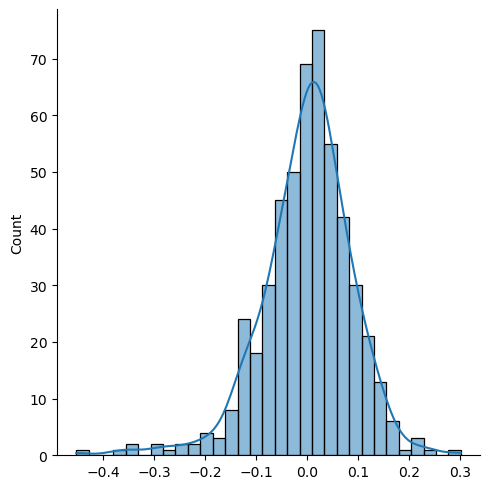

In [61]:
res = y_train - y_train_pred

sns.displot(res, kde=True)

We see that the error terms are normally distribution with mean as 0. This is allinged with the assumptions made for Linear Regression.

#### Step 5 - Predictions and Evaluation

Since we have finalised with the model and verified the error terms are normally distributed, we now proceed with the Predictions using the final model.
We will use the test dataset to predict the target variable cnt. 

In [62]:
# Apply the scaling on the test dataset

num_varlist

['temp', 'atemp', 'hum', 'windspeed', 'cnt']

In [63]:
bike_test[num_varlist] = scaler.transform(bike_test[num_varlist])

In [64]:
bike_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.0,220.0,...,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,...,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.1,0.027273,0.318182
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,...,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [65]:
# Separate target variable cnt
y_test = bike_test.pop('cnt')
x_test = bike_test

In [66]:
x_test_sm = sm.add_constant(x_test)
x_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,season_Spring,season_Summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thrusday,weekday_Tuesday,weekday_Wednesday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,...,0,0,1,0,0,0,0,0,0,1
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,...,0,0,0,0,0,0,0,1,0,0
299,1.0,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,...,1,0,0,0,0,1,0,0,0,1
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,...,0,0,0,0,0,0,0,1,0,0
152,1.0,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,...,0,0,0,0,0,1,0,0,0,0


In [67]:
model_col_list = x_train_lm.columns

In [68]:
x_test_sm = x_test_sm[model_col_list]
x_test_sm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 184 to 653
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   const                      220 non-null    float64
 1   yr                         220 non-null    int64  
 2   workingday                 220 non-null    int64  
 3   temp                       220 non-null    float64
 4   windspeed                  220 non-null    float64
 5   season_Summer              220 non-null    Int64  
 6   season_Winter              220 non-null    Int64  
 7   mnth_August                220 non-null    Int64  
 8   mnth_December              220 non-null    Int64  
 9   mnth_February              220 non-null    Int64  
 10  mnth_January               220 non-null    Int64  
 11  mnth_November              220 non-null    Int64  
 12  mnth_September             220 non-null    Int64  
 13  weekday_Saturday           220 non-null    Int64  
 1

In [69]:
x_test_sm.head()

,const,yr,workingday,temp,windspeed,season_Summer,season_Winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_November,mnth_September,weekday_Saturday,weathersit_LightSnow+Rain,weathersit_Mist+Cloudy
184,1.0,0,0,0.831783,0.084219,0,0,0,0,0,0,0,0,0,0,1
535,1.0,1,1,0.901354,0.153728,1,0,0,0,0,0,0,0,0,0,0
299,1.0,0,1,0.511964,0.334206,0,1,0,0,0,0,0,0,0,0,1
221,1.0,0,1,0.881625,0.339570,0,0,1,0,0,0,0,0,0,0,0
152,1.0,0,1,0.817246,0.537414,1,0,0,0,0,0,0,0,0,0,0


In [70]:
y_test_pred = lr_model.predict(x_test_sm)

#### R-Squared Value
The R-squared value provides the goodness of the fit for the model. The scale of R^2 is between 0-100%. It explains the variance of dependent variable which independent variables will be able to explain.

In [71]:
# R^2 value for Test and Predicted values.
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8095370585769065

#### Conclusion 
The regression model when applied on the test dataset gives R-quared value of 80.95%. The R-sqaured value on training dataset is 84.4%. These values are quite reasonable and indicates that the model which is based on the training data can be safely applied on the test dataset.

In [72]:
# the following are the coefficents and their corresponding parameters
lr_model.params

const                        0.155791
yr                           0.234418
workingday                   0.054179
temp                         0.439637
windspeed                   -0.164815
season_Summer                0.078066
season_Winter                0.132152
mnth_August                  0.044571
mnth_December               -0.053959
mnth_February               -0.046310
mnth_January                -0.079672
mnth_November               -0.043375
mnth_September               0.097811
weekday_Saturday             0.064574
weathersit_LightSnow+Rain   -0.295298
weathersit_Mist+Cloudy      -0.082215
dtype: float64

In [73]:
# Regression line is represented by following equation
n=0
equation = ''
for i in lr_model.params:
    #print(equation)
    if lr_model.params.index[n] == 'const':
        equation = str(round(lr_model.params.values[n], 3))
    else:
        equation= equation + " + " + str(round(lr_model.params.values[n], 3)) + ' * ' + lr_model.params.index[n]
    n+=1

In [74]:
equation

'0.156 + 0.234 * yr + 0.054 * workingday + 0.44 * temp + -0.165 * windspeed + 0.078 * season_Summer + 0.132 * season_Winter + 0.045 * mnth_August + -0.054 * mnth_December + -0.046 * mnth_February + -0.08 * mnth_January + -0.043 * mnth_November + 0.098 * mnth_September + 0.065 * weekday_Saturday + -0.295 * weathersit_LightSnow+Rain + -0.082 * weathersit_Mist+Cloudy'

Reqression Line represented by the by the following equation is the best fitted line from the above analysis.

cnt = 0.156 + 0.234 * yr + 0.054 * workingday + 0.44 * temp + -0.165 * windspeed + 0.078 * season_Summer + 0.132 * season_Winter + 0.045 * mnth_August + -0.054 * mnth_December + -0.046 * mnth_February + -0.08 * mnth_January + -0.043 * mnth_November + 0.098 * mnth_September + 0.065 * weekday_Saturday + -0.295 * weathersit_LightSnow+Rain + -0.082 * weathersit_Mist+Cloudy

The coefficients indicate
1. Positive coefficents indicate that the increase in variables will increase in value of the target variable.
2. Negative coefficents indicate that the increase in variables will decrease in value of the target variable.

From the above equation we conclude
1. From the R-squared value of training and test dataset we conclude that the variables can explain the about 81% of the demand in bike sharing.
2. Coefficents of the variables helps in understanding the magnitude of their impact on bike sharing.
3. We see that top three variables which positively impact are temp, yr and season_winter.
4. We see that top three variables which negatively impact are windspeed, weathersit_LightSnow+Rain and weathersit_Mist+Cloudy.
5. So from original dataset we see that major factors will be temp, season, weathersit and mnth.

#### Recommendations by Regression model
1. Increase in temp will drive higher demand for bike sharing.
2. During Winter season there is expected increase in numbers for bike sharing.
3. Demand is high during working day and saturdays.
4. Demand will be less on days with high wind speed.